<a href="https://colab.research.google.com/github/yuann403/financial/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install backtrader

# 1. 使用Python建立ARIMA模型，預測股票價格，並進行可視化。

In [3]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [4]:
# 輸入股票代號
stock_id = '2882.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-04-26,48.599998,49.200001,48.599998,48.900002,47.242374,13314079
1,2024-04-29,49.299999,50.900002,49.250000,50.799999,49.077965,54662846
2,2024-04-30,50.799999,51.200001,50.500000,50.500000,48.788136,35944685
3,2024-05-02,50.200001,50.700001,50.000000,50.299999,48.594913,23499014
4,2024-05-03,50.400002,50.700001,50.099998,50.200001,48.498306,14900507
...,...,...,...,...,...,...,...
114,2024-10-15,67.800003,68.800003,67.500000,68.800003,68.800003,28862968
115,2024-10-16,68.000000,68.599998,67.400002,67.800003,67.800003,21791724
116,2024-10-17,67.900002,68.699997,67.900002,68.599998,68.599998,13945412
117,2024-10-18,68.800003,69.900002,68.500000,69.800003,69.800003,42577824


In [5]:
# 處理數據，選擇收盤價作為分析對象
stock_data = df['Close']

# 拆分訓練集和測試集
train_size = int(len(stock_data) * 0.8)
train_data, test_data = stock_data[:train_size], stock_data[train_size:]

# 建立ARIMA模型
model = ARIMA(train_data, order=(4, 2, 2))
model_fit = model.fit()

# 進行預測
predictions = model_fit.forecast(steps=len(test_data))

# 計算誤差
error = mean_squared_error(test_data, predictions)
print(f'均方誤差: {error}')

均方誤差: 6.858905259845639


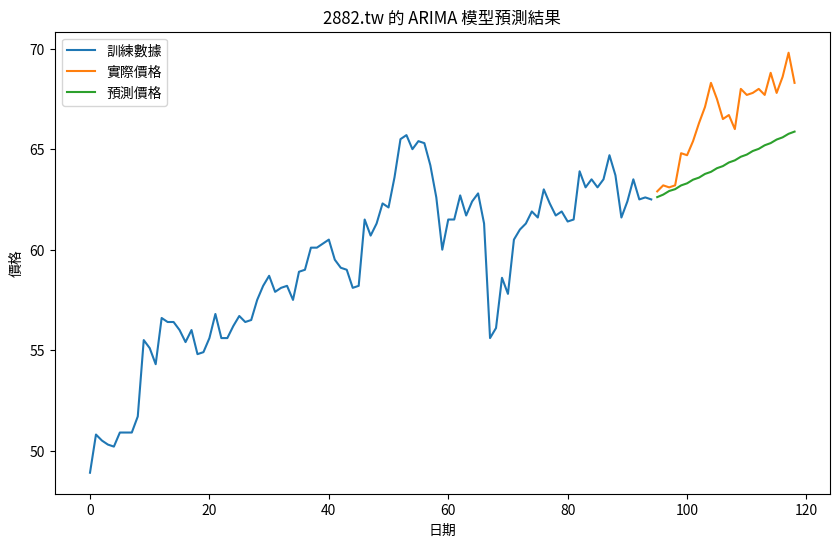

In [6]:
# 結果可視化
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='訓練數據')
plt.plot(test_data.index, test_data, label='實際價格')
plt.plot(test_data.index, predictions, label='預測價格')
plt.title(f'{stock_id} 的 ARIMA 模型預測結果')
plt.xlabel('日期')
plt.ylabel('價格')
plt.legend()
plt.show()

# 2. 使用Python設計一個量化交易策略，並使用歷史資料進行回測。

In [7]:
import backtrader as bt

In [8]:
# 定義均值回歸策略
class MeanReversionStrategy(bt.Strategy):
    params = (('period', 20),  # 移動平均的天數
          ('devfactor', 2),  # 標準差倍數
          ('size', 100))     # 每次交易的股數

    def __init__(self):
      # 計算移動平均和標準差
      self.sma = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.period)
      self.stddev = bt.indicators.StandardDeviation(self.data.close, period=self.params.period)
      self.buy_signal = []
      self.sell_signal = []

    def next(self):
      if not self.position:  # 沒有持倉
        # 如果價格低於移動平均減去2倍標準差，買入
        if self.data.close[0] < self.sma[0] - self.params.devfactor * self.stddev[0]:
          self.buy(size=self.params.size)
          self.buy_signal.append(len(self))  # 記錄買入點的索引
      else:
        # 如果價格高於移動平均加上2倍標準差，賣出
        if self.data.close[0] > self.sma[0] + self.params.devfactor * self.stddev[0]:
          self.sell(size=self.params.size)
          self.sell_signal.append(len(self))  # 記錄賣出點的索引

In [9]:
# 輸入股票代號
stock_id = '2882.tw'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = bt.feeds.PandasData(dataname=yf.download(stock_id, start=start, end=end))

[*********************100%***********************]  1 of 1 completed


In [10]:
# 創建回測引擎
cerebro = bt.Cerebro()

# 添加均值回歸策略
cerebro.addstrategy(MeanReversionStrategy)

# 添加數據
cerebro.adddata(df)

# 設定初始資金
cerebro.broker.setcash(100000.0)

# 設置佣金
cerebro.broker.setcommission(commission=0.001)  # 0.1% 的佣金

# 運行回測
print(f'初始資金: {cerebro.broker.getvalue():.2f}')
result = cerebro.run()
print(f'最終資金: {cerebro.broker.getvalue():.2f}')

初始資金: 100000.00
最終資金: 100837.75


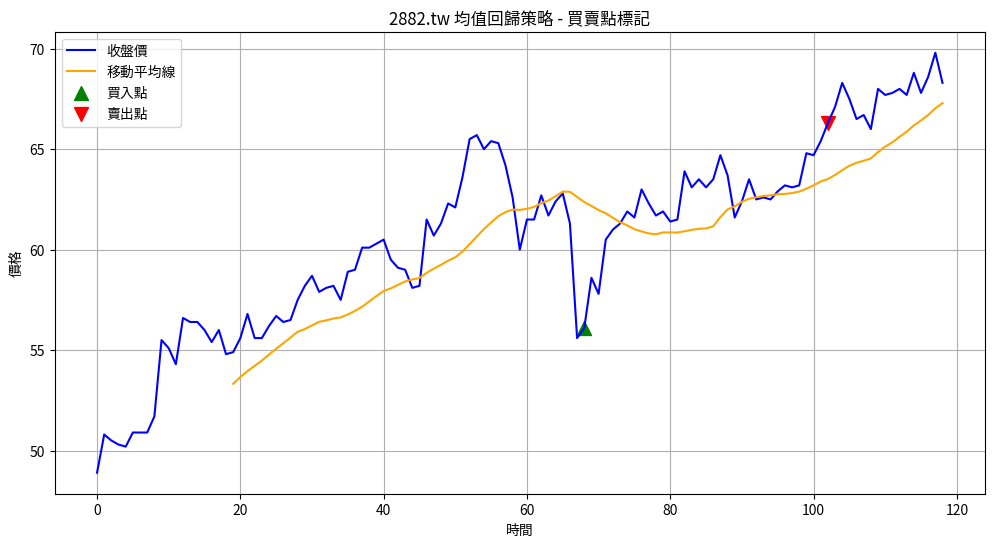

In [11]:
# 策略對象
strategy = result[0]

# 繪製價格走勢和交易點
plt.figure(figsize=(12, 6))
plt.plot(df.lines[0].array, label='收盤價', color='blue')

# 畫出移動平均線
plt.plot(strategy.sma.array, label='移動平均線', color='orange')

# 標記買入和賣出點
buy_signals = strategy.buy_signal
sell_signals = strategy.sell_signal

plt.scatter(buy_signals, [df.lines[0].array[date] for date in buy_signals], label='買入點', marker='^', color='green', s=100)
plt.scatter(sell_signals, [df.lines[0].array[date] for date in sell_signals], label='賣出點', marker='v', color='red', s=100)

plt.title(f'{stock_id} 均值回歸策略 - 買賣點標記')
plt.xlabel('時間')
plt.ylabel('價格')
plt.legend()
plt.grid()
plt.show()

# 在 Colab 上使用中文字體

In [2]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-10-23 07:55:07--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.202.100, 74.125.202.102, 74.125.202.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.202.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-23 07:55:07--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  81.1MB/s    in 0.2s    

2024-10-23 07:5